In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import pandas as pd
import joblib
import tensorflow as tf
import sys


project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)
    
from img2vec import rgb2emb

# Define the batch size for data processing
batch_size = 64


### read the data

In [3]:
train_dir = os.path.join( 'data', 'train.csv')
val_dir = os.path.join( 'data', 'val.csv')
test_dir = os.path.join( 'data', 'test.csv')

train_data = pd.read_csv(train_dir)
val_data = pd.read_csv(val_dir)
test_data = pd.read_csv(test_dir)

### add the path of the images

In [4]:
def construct_img_path(row):
    return os.path.join("data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,age_gender,img_path
0,39411334@N02,413,11043194586_986d3e52d5_o.jpg,"(25, 32)",f,"(25, 32)_f",data\faces\39411334@N02\coarse_tilt_aligned_fa...
1,20632896@N03,558,9824379664_0e1ae5f125_o.jpg,"(4, 6)",f,"(4, 6)_f",data\faces\20632896@N03\coarse_tilt_aligned_fa...
2,39615950@N00,750,10177473886_a6c3c8d8fe_o.jpg,"(38, 43)",f,"(38, 43)_f",data\faces\39615950@N00\coarse_tilt_aligned_fa...
3,7890646@N03,1392,10195451775_1f7021cda7_o.jpg,"(38, 43)",m,"(38, 43)_m",data\faces\7890646@N03\coarse_tilt_aligned_fac...
4,16166376@N00,354,8780198724_e465fb258c_o.jpg,"(25, 32)",m,"(25, 32)_m",data\faces\16166376@N00\coarse_tilt_aligned_fa...


### encode the labels

In [5]:
# Check if the encoder is already saved (in the `models` folder)
if os.path.exists(os.path.join('models', 'combined_encoder.pkl')):
    combined_encoder = joblib.load(os.path.join('models', 'combined_encoder.pkl'))
    print("Combined encoder loaded successfully.")
else:
    combined_encoder = LabelEncoder()
    combined_encoder.fit(train_data['age_gender'])
    joblib.dump(combined_encoder, os.path.join('models', 'combined_encoder.pkl'))
    print("Combined encoder created and saved successfully.")

# Encode the labels
train_data['encoded_label'] = combined_encoder.transform(train_data['age_gender'])
val_data['encoded_label'] = combined_encoder.transform(val_data['age_gender'])
test_data['encoded_label'] = combined_encoder.transform(test_data['age_gender'])

num_classes = len(combined_encoder.classes_)
print(f"Number of combined classes: {num_classes}")
print("Combined classes:", combined_encoder.classes_)    

Combined encoder loaded successfully.
Number of combined classes: 16
Combined classes: ['(0, 2)_f' '(0, 2)_m' '(15, 20)_f' '(15, 20)_m' '(25, 32)_f' '(25, 32)_m'
 '(38, 43)_f' '(38, 43)_m' '(4, 6)_f' '(4, 6)_m' '(48, 53)_f' '(48, 53)_m'
 '(60, 100)_f' '(60, 100)_m' '(8, 12)_f' '(8, 12)_m']


### Extract image paths and labels

In [6]:
train_image_paths = train_data['img_path'].tolist()
train_labels = train_data['encoded_label'].values

val_image_paths = val_data['img_path'].tolist()
val_labels = val_data['encoded_label'].values

test_image_paths = test_data['img_path'].tolist()
test_labels = test_data['encoded_label'].values

### Define function that process features in batches

In [7]:
def preprocess_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = rgb2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Preprocess and save features

In [9]:
# Check if the scaler is already saved
if os.path.exists(os.path.join('models', 'combined_scaler.pkl')):
    combined_scaler = joblib.load(os.path.join('models', 'combined_scaler.pkl'))
    print("Scaler loaded successfully.")
else:
    combined_scaler = StandardScaler()

# Check if the features are already saved
if os.path.exists(os.path.join('data', 'train_features_rgb.npy')):
    print("Loading pre-processed features from disk")
    train_features = np.load(os.path.join('data', 'train_features_rgb.npy'))
    val_features = np.load(os.path.join('data', 'val_features_rgb.npy'))
    test_features = np.load(os.path.join('data', 'test_features_rgb.npy'))
else:
    train_features = preprocess_features(train_image_paths, os.path.join('data', 'train_features_rgb.npy'), batch_size)
    val_features = preprocess_features(val_image_paths, os.path.join('data', 'val_features_rgb.npy'), batch_size)
    test_features = preprocess_features(test_image_paths, os.path.join('data', 'test_features_rgb.npy'), batch_size)

    # Fit the scaler on the training features
    combined_scaler.fit(train_features)
    joblib.dump(combined_scaler, os.path.join('models', 'combined_scaler.pkl'))
    print("Scaler created and saved successfully.")

    # Transform the features
    train_features = combined_scaler.transform(train_features)
    val_features = combined_scaler.transform(val_features)
    test_features = combined_scaler.transform(test_features)

    # Save the scaled features
    np.save(os.path.join('data', 'train_features_rgb.npy'), train_features)
    np.save(os.path.join('data', 'val_features_rgb.npy'), val_features)
    np.save(os.path.join('data', 'test_features_rgb.npy'), test_features)

Scaler loaded successfully.
Loading pre-processed features from disk


## define & train the model

### common functions

In [10]:
# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
# function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, encoder, title='Confusion Matrix', cmap=None, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 10))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=combined_encoder.classes_,
            yticklabels=combined_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

    
# function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Softmax model

In [24]:
softmax_model = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs',
    class_weight='balanced',
    C=0.001,
    max_iter=1000,
    random_state=42
)
softmax_model.fit(train_features, train_labels)

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

Softmax Model
Train Accuracy: 0.7331
Test Accuracy: 0.3237
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.26      0.13      0.17       192
    (0, 2)_m       0.65      0.89      0.75       291
  (15, 20)_f       0.12      0.14      0.13       152
  (15, 20)_m       0.10      0.22      0.14        73
  (25, 32)_f       0.40      0.23      0.30       558
  (25, 32)_m       0.51      0.41      0.45       478
  (38, 43)_f       0.29      0.25      0.27       297
  (38, 43)_m       0.22      0.23      0.22       246
    (4, 6)_f       0.20      0.26      0.23       193
    (4, 6)_m       0.60      0.34      0.44       377
  (48, 53)_f       0.09      0.12      0.10       145
  (48, 53)_m       0.19      0.39      0.26       113
 (60, 100)_f       0.24      0.25      0.24       137
 (60, 100)_m       0.35      0.42      0.38       137
   (8, 12)_f       0.24      0.30      0.26       174
   (8, 12)_m       0.18      0.28      0.22       166


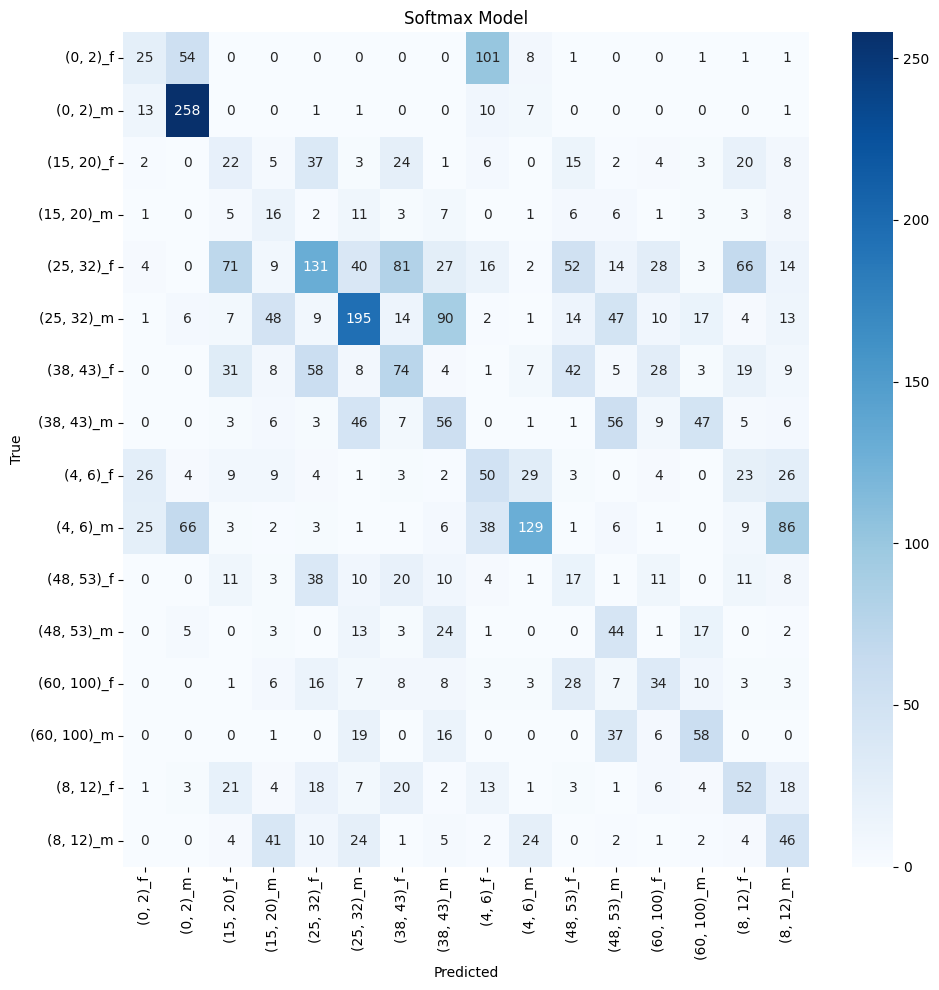

In [25]:
# evaluate the model
softmax_train_preds = softmax_model.predict(train_features)
softmax_train_acc = np.mean(softmax_train_preds == train_labels)
softmax_test_preds = softmax_model.predict(test_features)
softmax_test_acc = np.mean(softmax_test_preds == test_labels)

print("Softmax Model")
print(f"Train Accuracy: {softmax_train_acc:.4f}")
print(f"Test Accuracy: {softmax_test_acc:.4f}")


# Print the classification report
print("Classification Report")
print(classification_report(test_labels, softmax_test_preds, target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(test_labels, softmax_test_preds, combined_encoder, title="Softmax Model", cmap="Blues")

### SVM model

In [34]:
svm_model = SVC(kernel='rbf', C=0.01, gamma='scale', probability=True, random_state=42)
svm_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(svm_model, os.path.join('models', 'svm_model_rgb.pkl'))

['models\\svm_model_rgb.pkl']

SVM Model
Train Accuracy: 0.2045
Test Accuracy: 0.1751
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.00      0.00      0.00       192
    (0, 2)_m       0.79      0.33      0.46       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.00      0.00      0.00        73
  (25, 32)_f       0.15      1.00      0.27       558
  (25, 32)_m       0.00      0.00      0.00       478
  (38, 43)_f       0.00      0.00      0.00       297
  (38, 43)_m       0.00      0.00      0.00       246
    (4, 6)_f       0.00      0.00      0.00       193
    (4, 6)_m       0.00      0.00      0.00       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.00      0.00      0.00       137
   (8, 12)_f       0.00      0.00      0.00       174
   (8, 12)_m       0.00      0.00      0.00       166

   

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

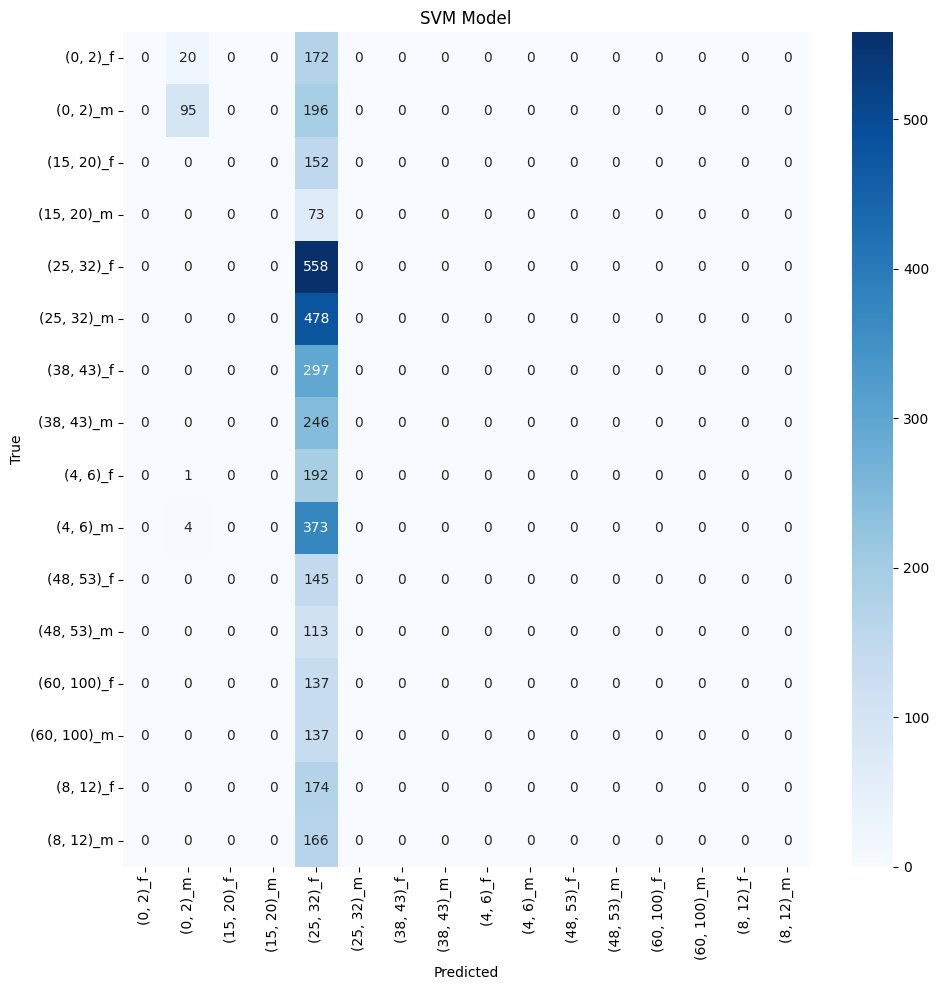

In [35]:
# evaluate the model
svm_train_preds = svm_model.predict(train_features)
svm_train_acc = np.mean(svm_train_preds == train_labels)
svm_test_preds = svm_model.predict(test_features)
svm_test_acc = np.mean(svm_test_preds == test_labels)

print("SVM Model")
print(f"Train Accuracy: {svm_train_acc:.4f}")
print(f"Test Accuracy: {svm_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(classification_report(test_labels, svm_test_preds, target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(test_labels, svm_test_preds, combined_encoder, title="SVM Model", cmap="Blues")

### random forest model

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(rf_model, os.path.join('models', 'rf_model_rgb.pkl'))

['models\\rf_model_rgb.pkl']

Random Forest Model
Train Accuracy: 0.7728
Test Accuracy: 0.3218
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.57      0.02      0.04       192
    (0, 2)_m       0.48      0.94      0.63       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.00      0.00      0.00        73
  (25, 32)_f       0.29      0.84      0.43       558
  (25, 32)_m       0.33      0.65      0.44       478
  (38, 43)_f       0.00      0.00      0.00       297
  (38, 43)_m       0.25      0.23      0.24       246
    (4, 6)_f       0.23      0.31      0.26       193
    (4, 6)_m       0.78      0.04      0.07       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.00      0.00      0.00       137
   (8, 12)_f       0.30      0.05      0.08       174
   (8, 12)_m       0.12      0.05      0.07     

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

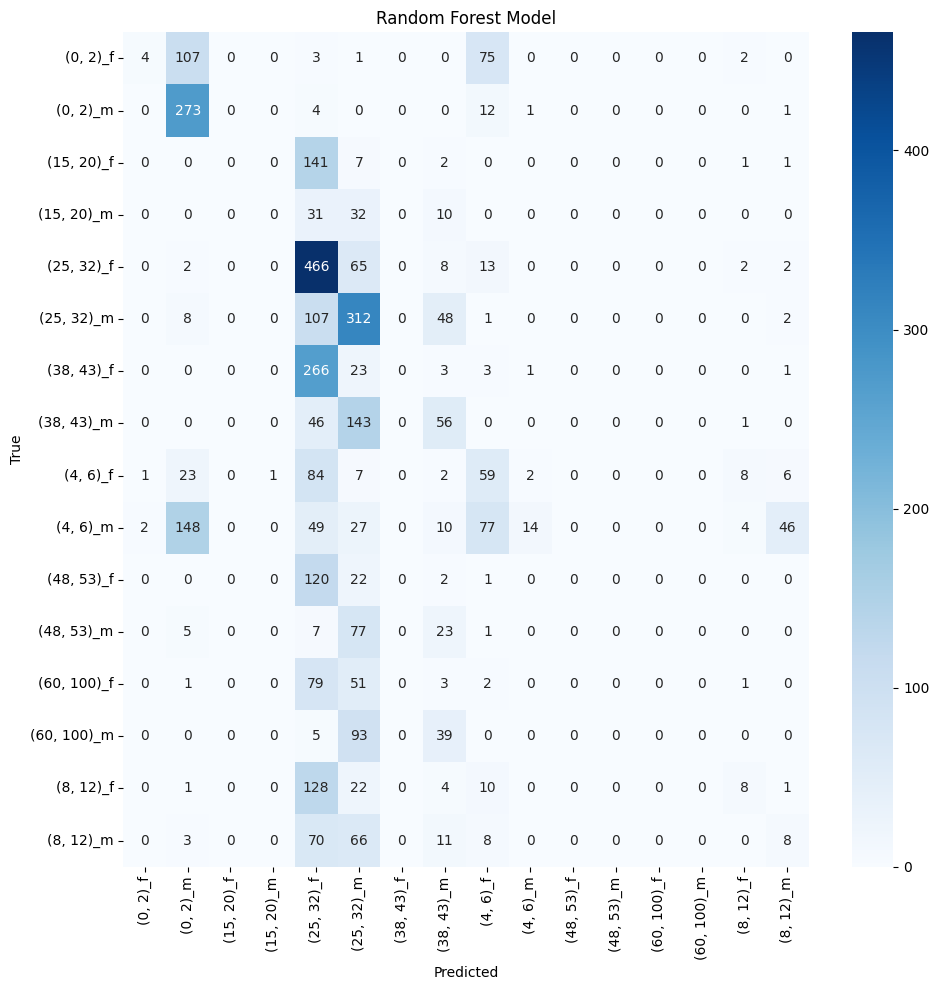

In [29]:
# evaluate the model
rf_train_preds = rf_model.predict(train_features)
rf_train_acc = np.mean(rf_train_preds == train_labels)
rf_test_preds = rf_model.predict(test_features)
rf_test_acc = np.mean(rf_test_preds == test_labels)

print("Random Forest Model")
print(f"Train Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(classification_report(test_labels, rf_test_preds, target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(test_labels, rf_test_preds, combined_encoder, title="Random Forest Model", cmap="Blues")

### Adaboost model

In [30]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(adaboost_model, os.path.join('models', 'adaboost_model_rgb.pkl'))

['models\\adaboost_model_rgb.pkl']

AdaBoost Model
Train Accuracy: 0.3716
Test Accuracy: 0.3162
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.13      0.03      0.04       192
    (0, 2)_m       0.62      0.81      0.70       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.00      0.00      0.00        73
  (25, 32)_f       0.31      0.62      0.41       558
  (25, 32)_m       0.32      0.50      0.39       478
  (38, 43)_f       0.26      0.17      0.21       297
  (38, 43)_m       0.22      0.36      0.27       246
    (4, 6)_f       0.18      0.18      0.18       193
    (4, 6)_m       0.49      0.34      0.40       377
  (48, 53)_f       0.14      0.01      0.01       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.20      0.01      0.03       137
 (60, 100)_m       0.29      0.03      0.05       137
   (8, 12)_f       0.08      0.08      0.08       174
   (8, 12)_m       0.21      0.19      0.20       166

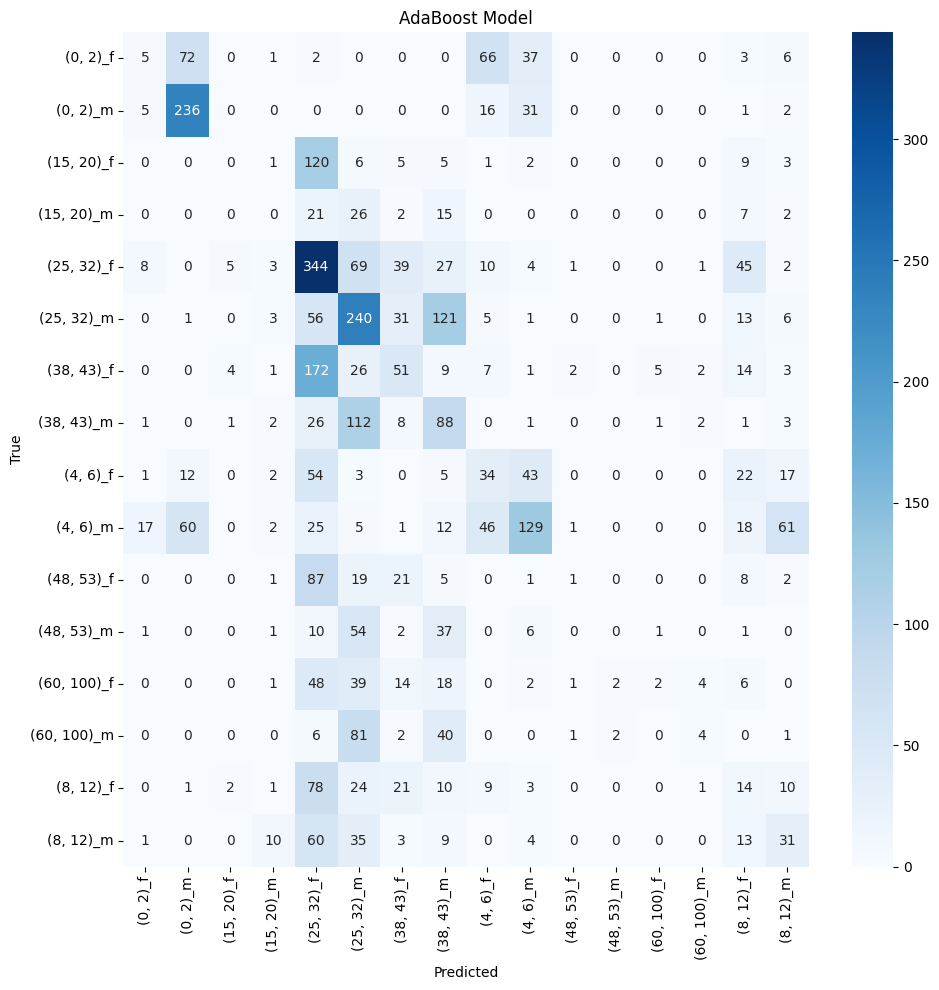

In [31]:
# evaluate the model
adaboost_train_preds = adaboost_model.predict(train_features)
adaboost_train_acc = np.mean(adaboost_train_preds == train_labels)
adaboost_test_preds = adaboost_model.predict(test_features)
adaboost_test_acc = np.mean(adaboost_test_preds == test_labels)

print("AdaBoost Model")
print(f"Train Accuracy: {adaboost_train_acc:.4f}")
print(f"Test Accuracy: {adaboost_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(classification_report(test_labels, adaboost_test_preds, target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(test_labels, adaboost_test_preds, combined_encoder, title="AdaBoost Model", cmap="Blues")

### KNN model

KNN Model with 1 neighbors
Train Accuracy: 0.9998
Test Accuracy: 0.1917
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.17      0.12      0.14       192
    (0, 2)_m       0.55      0.72      0.62       291
  (15, 20)_f       0.09      0.11      0.10       152
  (15, 20)_m       0.02      0.03      0.02        73
  (25, 32)_f       0.25      0.24      0.25       558
  (25, 32)_m       0.25      0.19      0.22       478
  (38, 43)_f       0.10      0.11      0.11       297
  (38, 43)_m       0.13      0.16      0.14       246
    (4, 6)_f       0.14      0.20      0.16       193
    (4, 6)_m       0.31      0.11      0.16       377
  (48, 53)_f       0.08      0.06      0.07       145
  (48, 53)_m       0.09      0.09      0.09       113
 (60, 100)_f       0.06      0.03      0.04       137
 (60, 100)_m       0.26      0.14      0.18       137
   (8, 12)_f       0.06      0.13      0.09       174
   (8, 12)_m       0.10      0.14      0.

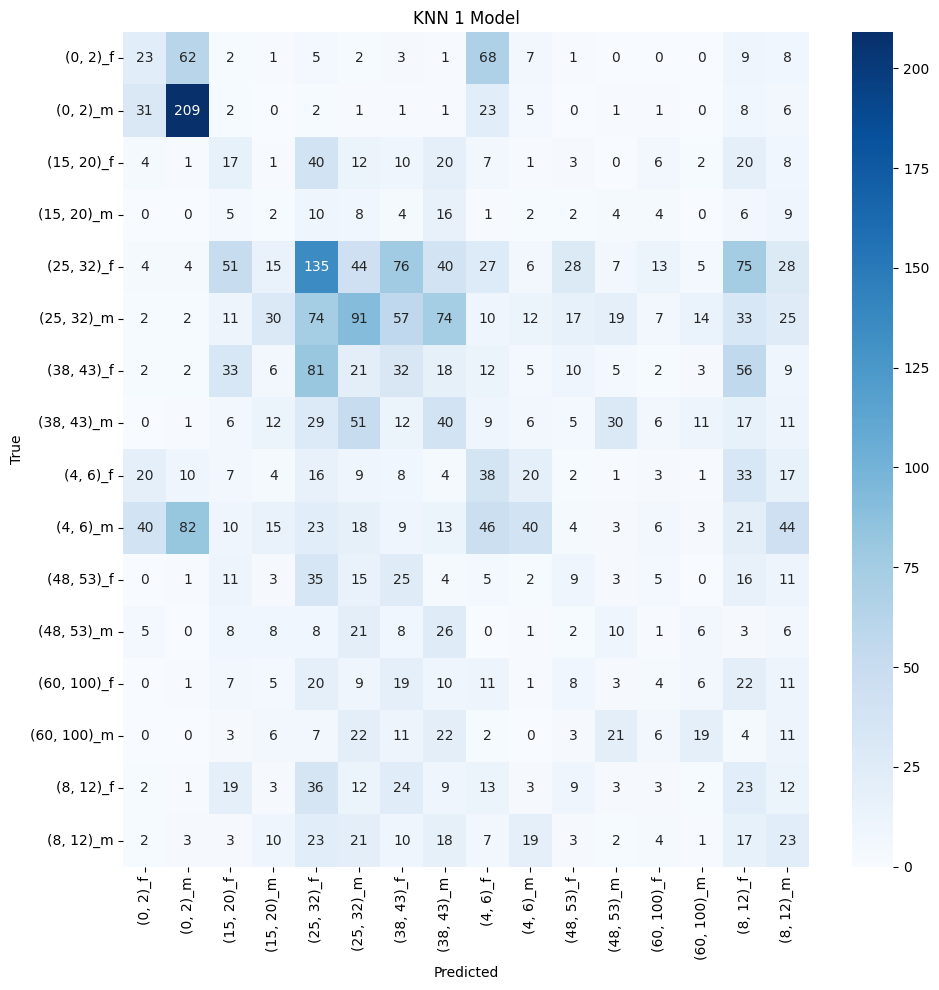

KNN Model with 3 neighbors
Train Accuracy: 0.7778
Test Accuracy: 0.2092
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.23      0.27      0.25       192
    (0, 2)_m       0.51      0.77      0.61       291
  (15, 20)_f       0.08      0.21      0.12       152
  (15, 20)_m       0.03      0.08      0.04        73
  (25, 32)_f       0.24      0.34      0.28       558
  (25, 32)_m       0.26      0.23      0.25       478
  (38, 43)_f       0.12      0.09      0.10       297
  (38, 43)_m       0.14      0.13      0.14       246
    (4, 6)_f       0.17      0.18      0.17       193
    (4, 6)_m       0.42      0.07      0.12       377
  (48, 53)_f       0.02      0.01      0.01       145
  (48, 53)_m       0.10      0.04      0.06       113
 (60, 100)_f       0.16      0.03      0.05       137
 (60, 100)_m       0.28      0.09      0.14       137
   (8, 12)_f       0.05      0.06      0.06       174
   (8, 12)_m       0.10      0.07      0.

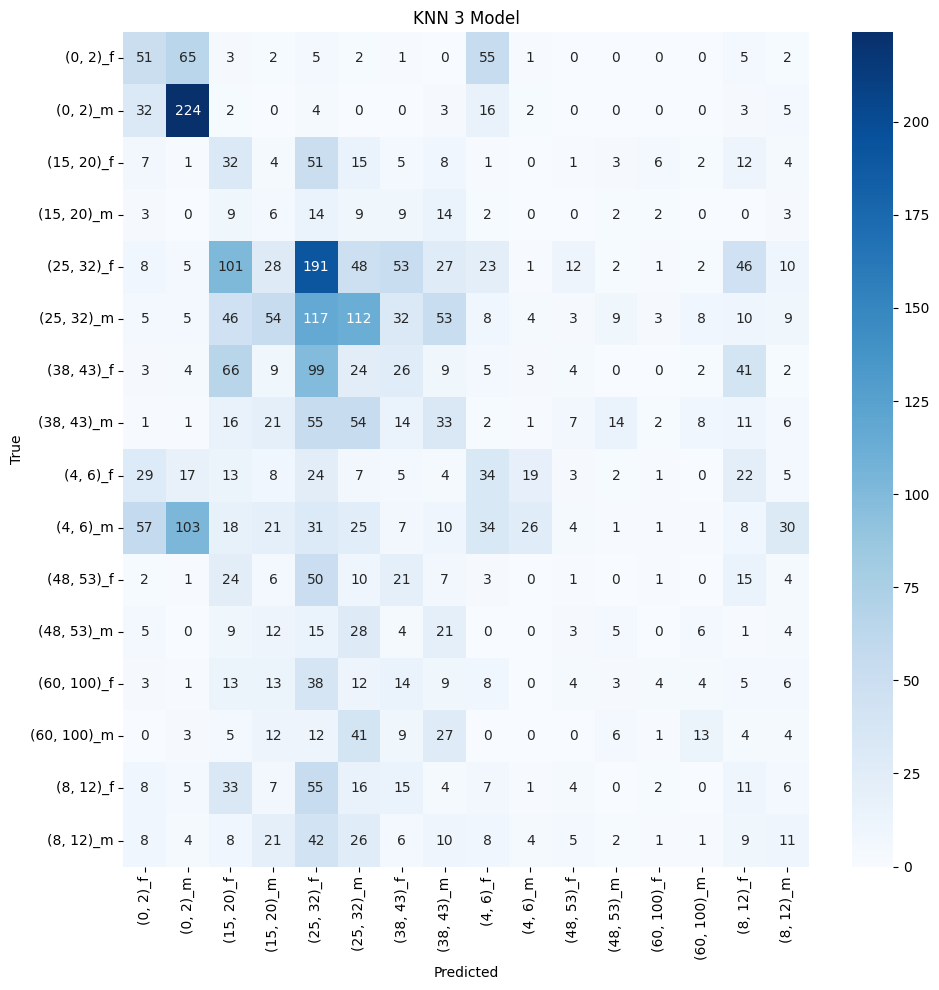

KNN Model with 5 neighbors
Train Accuracy: 0.7248
Test Accuracy: 0.2212
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.22      0.21      0.21       192
    (0, 2)_m       0.51      0.79      0.62       291
  (15, 20)_f       0.08      0.17      0.11       152
  (15, 20)_m       0.03      0.07      0.04        73
  (25, 32)_f       0.26      0.36      0.30       558
  (25, 32)_m       0.30      0.26      0.28       478
  (38, 43)_f       0.15      0.12      0.14       297
  (38, 43)_m       0.15      0.19      0.17       246
    (4, 6)_f       0.15      0.17      0.16       193
    (4, 6)_m       0.39      0.06      0.11       377
  (48, 53)_f       0.04      0.01      0.02       145
  (48, 53)_m       0.12      0.05      0.07       113
 (60, 100)_f       0.11      0.02      0.04       137
 (60, 100)_m       0.32      0.14      0.19       137
   (8, 12)_f       0.06      0.08      0.07       174
   (8, 12)_m       0.08      0.08      0.

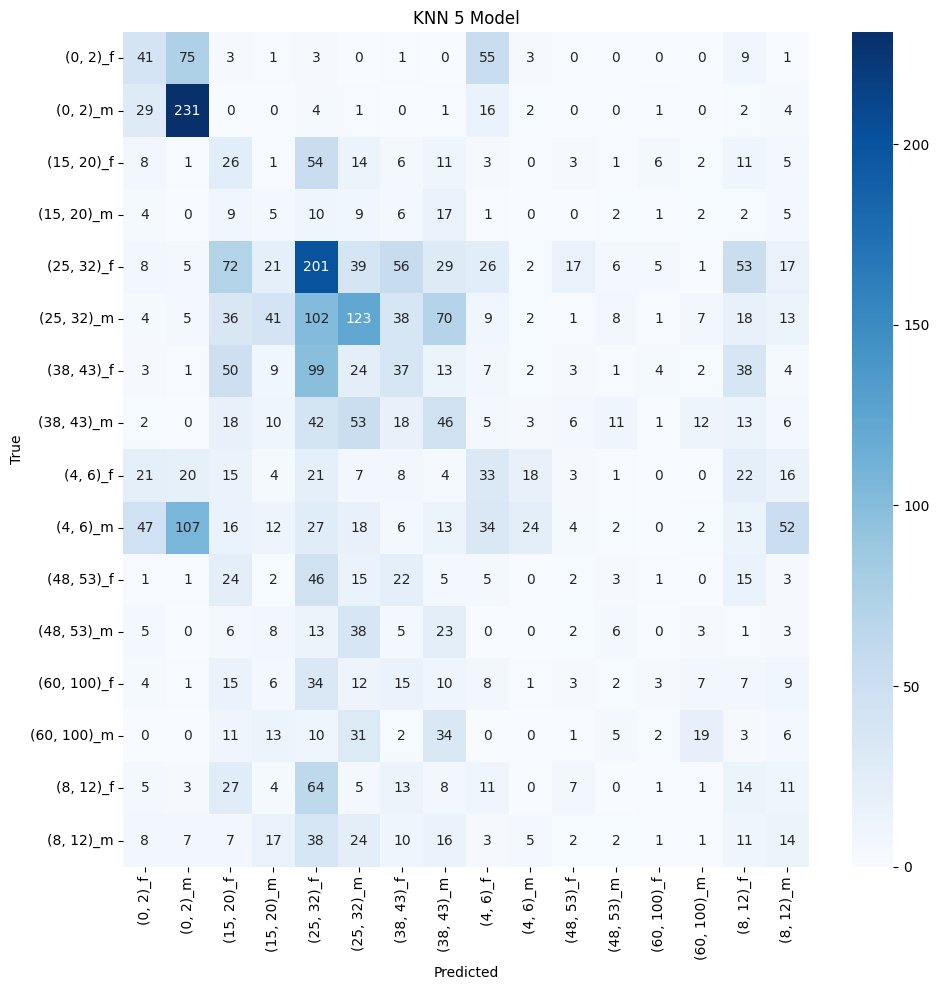

KNN Model with 7 neighbors
Train Accuracy: 0.6886
Test Accuracy: 0.2279
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.25      0.20      0.23       192
    (0, 2)_m       0.53      0.84      0.65       291
  (15, 20)_f       0.08      0.16      0.11       152
  (15, 20)_m       0.04      0.05      0.04        73
  (25, 32)_f       0.25      0.36      0.30       558
  (25, 32)_m       0.28      0.27      0.27       478
  (38, 43)_f       0.14      0.12      0.13       297
  (38, 43)_m       0.14      0.19      0.16       246
    (4, 6)_f       0.16      0.20      0.18       193
    (4, 6)_m       0.39      0.07      0.12       377
  (48, 53)_f       0.02      0.01      0.01       145
  (48, 53)_m       0.17      0.06      0.09       113
 (60, 100)_f       0.19      0.04      0.06       137
 (60, 100)_m       0.31      0.11      0.16       137
   (8, 12)_f       0.08      0.10      0.09       174
   (8, 12)_m       0.09      0.08      0.

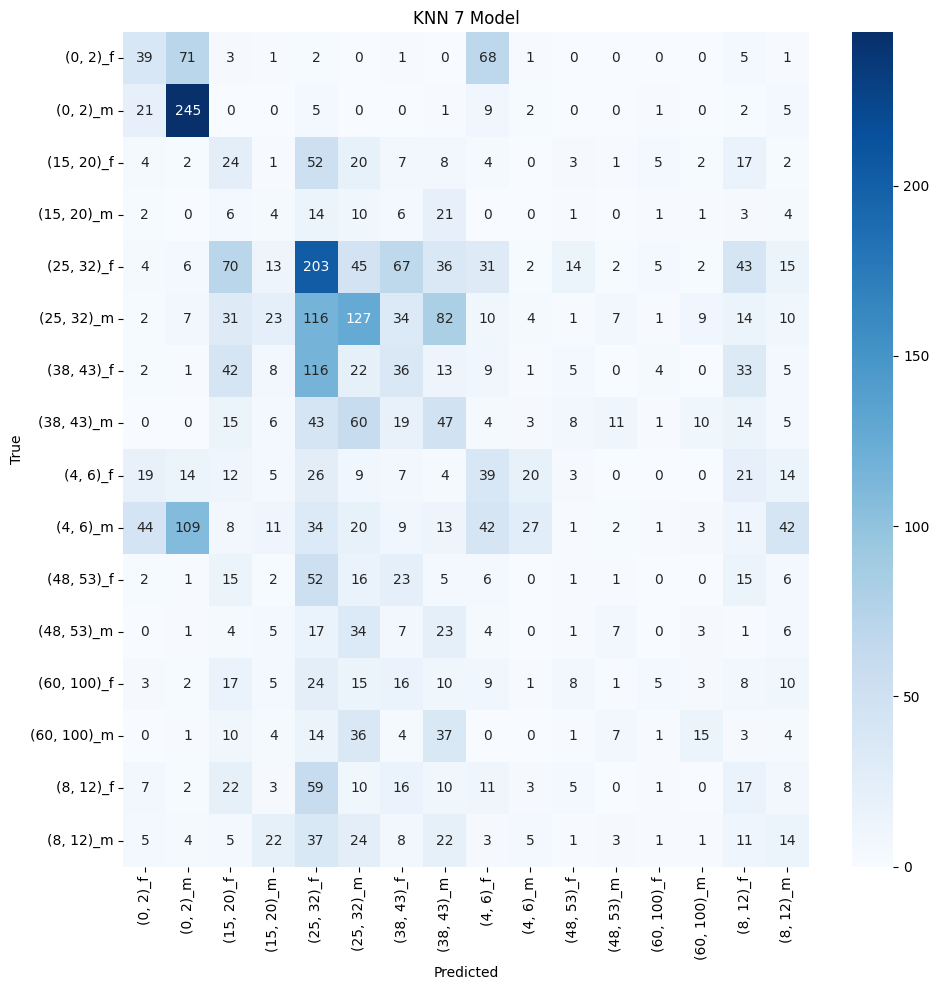

KNN Model with 9 neighbors
Train Accuracy: 0.6658
Test Accuracy: 0.2333
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.20      0.14      0.16       192
    (0, 2)_m       0.52      0.85      0.64       291
  (15, 20)_f       0.09      0.16      0.12       152
  (15, 20)_m       0.03      0.04      0.04        73
  (25, 32)_f       0.25      0.38      0.30       558
  (25, 32)_m       0.30      0.30      0.30       478
  (38, 43)_f       0.12      0.10      0.11       297
  (38, 43)_m       0.17      0.23      0.19       246
    (4, 6)_f       0.15      0.21      0.18       193
    (4, 6)_m       0.43      0.06      0.11       377
  (48, 53)_f       0.02      0.01      0.01       145
  (48, 53)_m       0.20      0.06      0.09       113
 (60, 100)_f       0.20      0.03      0.05       137
 (60, 100)_m       0.38      0.15      0.21       137
   (8, 12)_f       0.08      0.10      0.09       174
   (8, 12)_m       0.09      0.08      0.

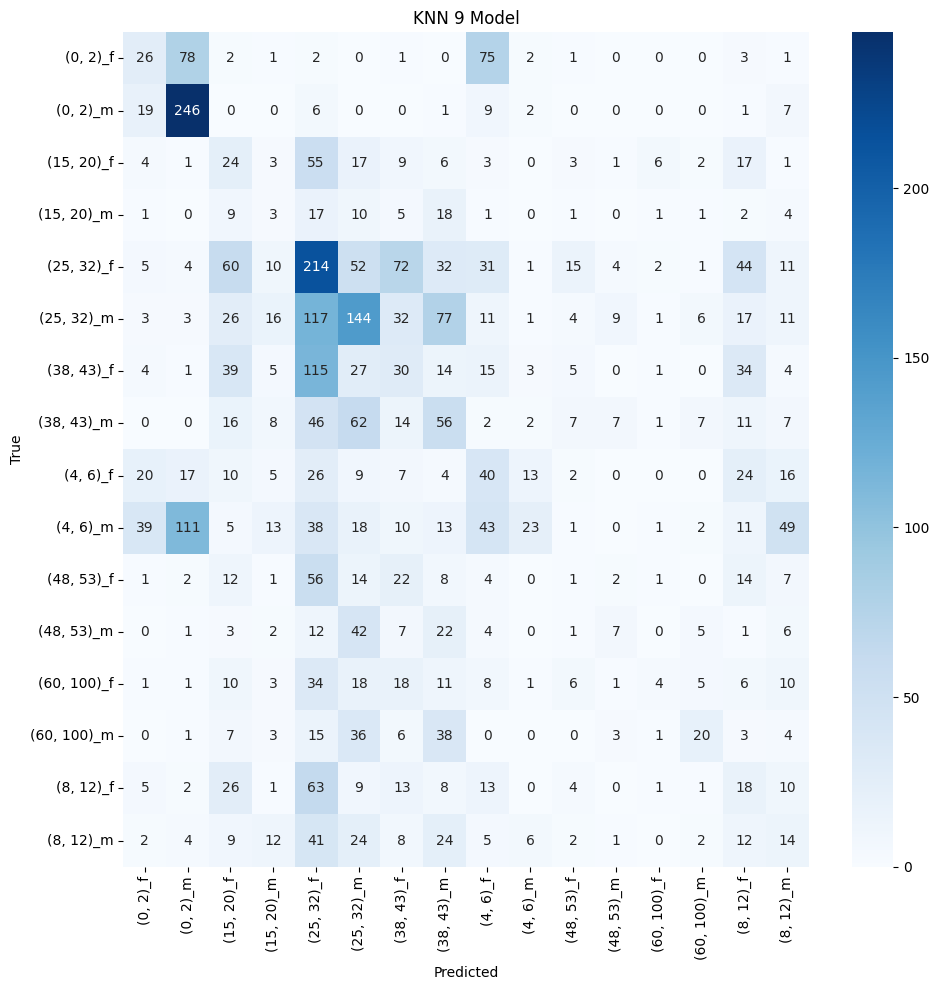

In [36]:
for i in range(1,10,2):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(train_features, train_labels)
    knn_train_preds = knn_model.predict(train_features)
    knn_train_acc = np.mean(knn_train_preds == train_labels)
    knn_test_preds = knn_model.predict(test_features)
    knn_test_acc = np.mean(knn_test_preds == test_labels)
    print(f"KNN Model with {i} neighbors")
    print(f"Train Accuracy: {knn_train_acc:.4f}")
    print(f"Test Accuracy: {knn_test_acc:.4f}")
    joblib.dump(knn_model, os.path.join('models', f'knn{i}_model_rgb.pkl'))
    # Print the classification report
    print("Classification Report")
    print(classification_report(test_labels, knn_test_preds, target_names=combined_encoder.classes_))

    # Plot the confusion matrix
    plot_confusion_matrix(test_labels, knn_test_preds, combined_encoder, title=f"KNN {i} Model", cmap="Blues")

### Multi-layer model

In [ ]:
mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

class_weights = compute_class_weight(class_weight='balanced', 
                                    classes=np.unique(train_labels), 
                                    y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

mlp_history = mlp_model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=15,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# save the model to disk
mlp_model.save(os.path.join('models', 'mlp_model_rgb.h5'))


c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1708 - loss: 2.7808 - val_accuracy: 0.4067 - val_loss: 1.7021
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3291 - loss: 1.9347 - val_accuracy: 0.4779 - val_loss: 1.5056
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3904 - loss: 1.6818 - val_accuracy: 0.4938 - val_loss: 1.4237
Epoch 4/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4427 - loss: 1.4733 - val_accuracy: 0.5211 - val_loss: 1.3592
Epoch 5/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4667 - loss: 1.3889 - val_accuracy: 0.5376 - val_loss: 1.2947
Epoch 6/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5079 - loss: 1.2464 - val_accuracy: 0.5478 - val_loss: 1.2471
Epoch 7/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5327 - loss: 1.1665 - val_accuracy: 0.5616 - val_loss: 1.2201
Epoch 8/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5471 - loss: 1.0938 - val_accuracy: 0.

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP Model
Train Accuracy: 0.7950
Test Accuracy: 0.3478
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.29      0.18      0.22       192
    (0, 2)_m       0.70      0.86      0.77       291
  (15, 20)_f       0.11      0.11      0.11       152
  (15, 20)_m       0.07      0.12      0.09        73
  (25, 32)_f       0.40      0.27      0.32       558
  (25, 32)_m       0.52      0.51      0.51       478
  (38, 43)_f       0.26      0.32      0.29       297
  (38, 43)_m       0.23      0.25      0.24       246
    (4, 6)_f       0.27      0.35      0.30       193
    (4, 6)_m       0.65      0.39      0.49       377
  (48, 53)_f       0.11      0.11      0.11       145
  (48, 53)_m       0.21      0.38      0.27       113
 (60, 100)_f       0.31      0.19      0.23       137
 (60, 100)_m       0.39      0.33      0.36       137
   (8, 12)_f       0.21      0

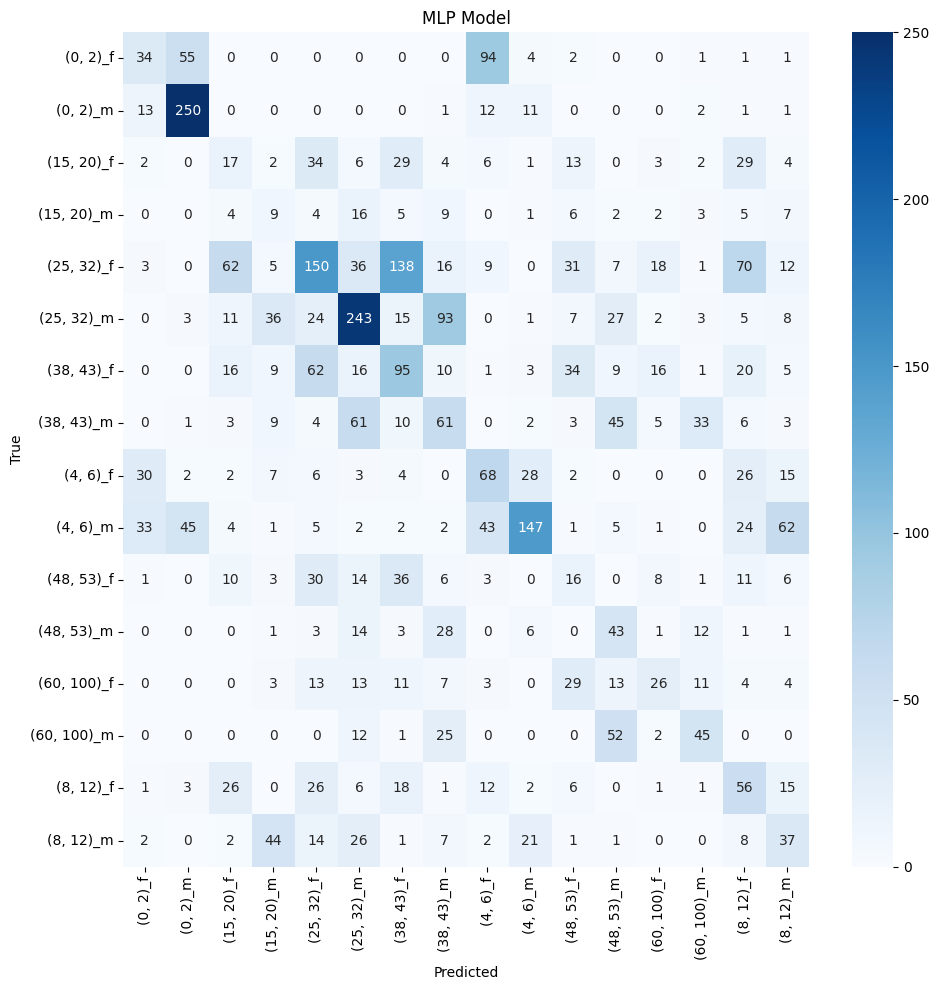

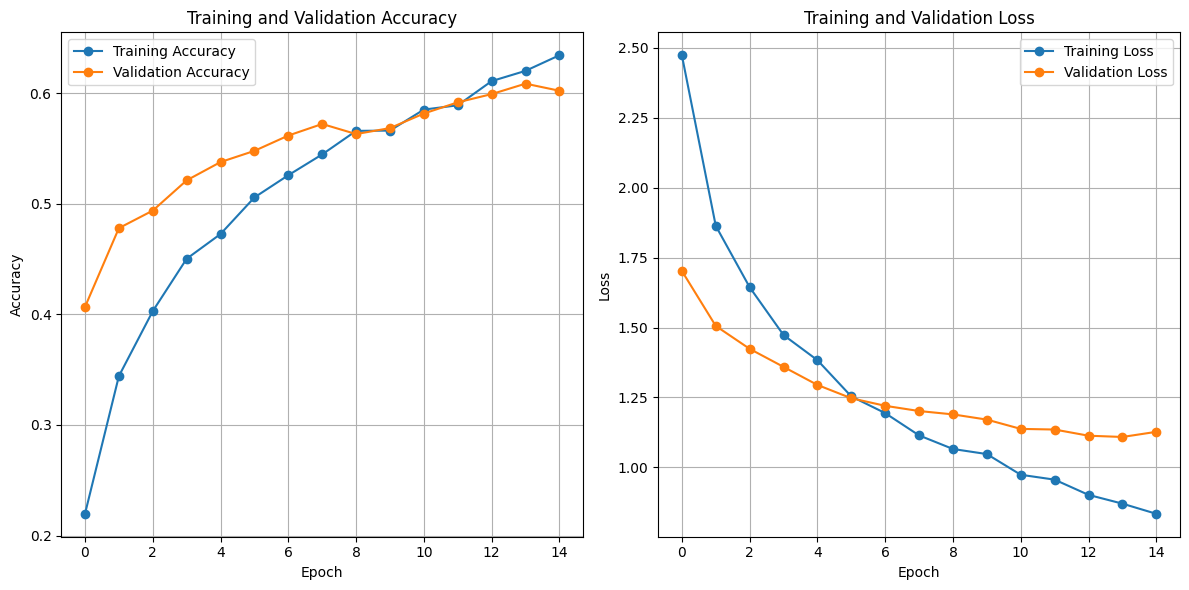

In [47]:
#evaluate the model
mlp_train_preds = mlp_model.predict(train_features)
mlp_train_acc = np.mean(np.argmax(mlp_train_preds, axis=1) == train_labels)
mlp_test_preds = mlp_model.predict(test_features)
mlp_test_acc = np.mean(np.argmax(mlp_test_preds, axis=1) == test_labels)

print("MLP Model")
print(f"Train Accuracy: {mlp_train_acc:.4f}")
print(f"Test Accuracy: {mlp_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(classification_report(test_labels, np.argmax(mlp_test_preds, axis=1), target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(test_labels, np.argmax(mlp_test_preds, axis=1), combined_encoder, title="MLP Model", cmap="Blues")

# Plot the training history
plot_training_history(mlp_history)

### CNN model
this model does not use the extracted features, it uses the images directly

In [12]:
# Build CNN Architecture
cnn_model = Sequential()

# Add convolutional layers with ReLU activation and max pooling
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
cnn_model.add(Flatten())

# Add dense layers with dropout for regularization
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))

# Output layer with softmax activation for classification
cnn_model.add(Dense(len(combined_encoder.classes_), activation='softmax'))

# Compile the cnn_model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='img_path',
    y_col='encoded_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

Found 11850 validated image filenames.
Found 2963 validated image filenames.
Found 3729 validated image filenames.


In [15]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 353s 950ms/step - accuracy: 0.1419 - loss: 2.6333 - val_accuracy: 0.2008 - val_loss: 2.5025
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 183s 492ms/step - accuracy: 0.2005 - loss: 2.5192 - val_accuracy: 0.2535 - val_loss: 2.3657
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 254s 685ms/step - accuracy: 0.2255 - loss: 2.4442 - val_accuracy: 0.3071 - val_loss: 2.1677
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 165s 444ms/step - accuracy: 0.2628 - loss: 2.3155 - val_accuracy: 0.3132 - val_loss: 2.0914
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 164s 441ms/step - accuracy: 0.2751 - loss: 2.2563 - val_accuracy: 0.3220 - val_loss: 2.0639
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 145s 391ms/step - accuracy: 0.2915 - loss: 2.2122 - val_accuracy: 0.3429 - val_loss: 2.0262
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 162s 435ms/step - accuracy: 0.3057 - loss: 2.1460 - val_accuracy: 0.3358 - val_loss: 2.0062
Epoch 8/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 121s 327ms/step - accuracy: 0.3233 -

In [16]:
# Save the model
cnn_model.save(os.path.join('models', 'cnn_model_rgb.h5'))

117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.3297 - loss: 2.0984
Test Loss: 2.0806100368499756
Test Accuracy: 0.32984715700149536
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.07      0.03      0.04       192
    (0, 2)_m       0.09      0.18      0.12       291
  (15, 20)_f       0.03      0.01      0.01       152
  (15, 20)_m       0.01      0.03      0.02        73
  (25, 32)_f       0.15      0.33      0.21       558
  (25, 32)_m       0.14      0.20      0.16       478
  (38, 43)_f       0.20      0.00      0.01       297
  (38, 43)_m       0.08      0.11      0.09       246
    (4, 6)_f       0.05      0.06      0.05       193
    (4, 6)_m       0.12      0.02      0.04       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.04      0.02   

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

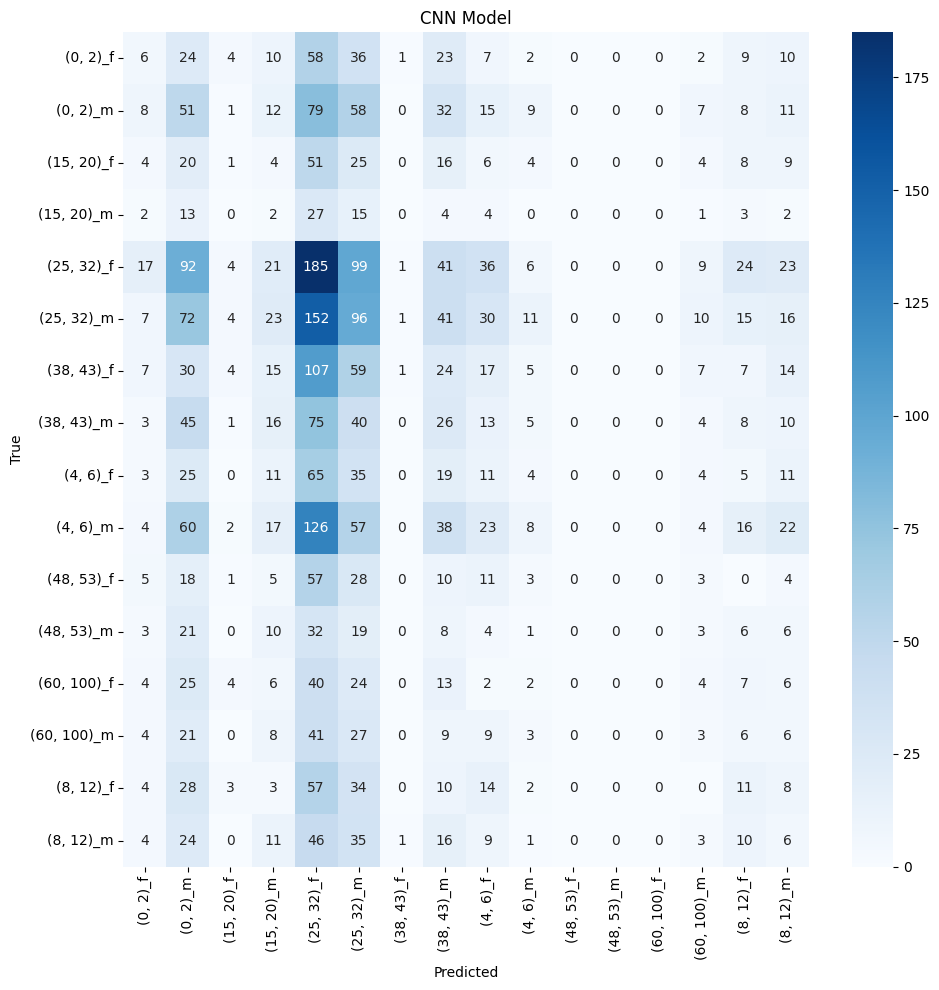

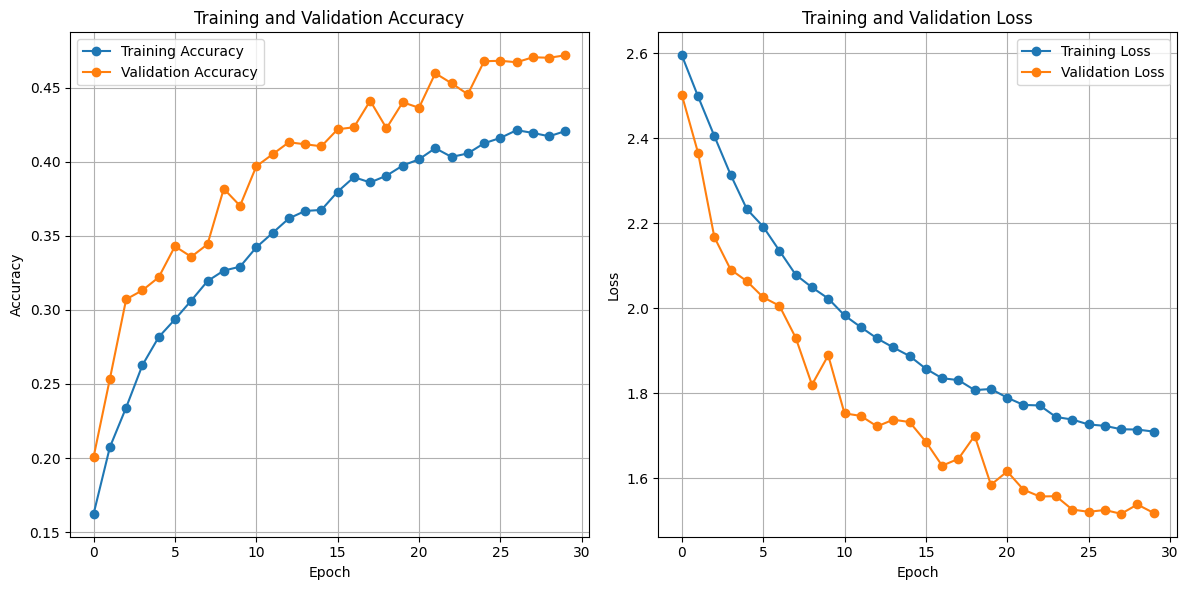

In [19]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test set
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data['encoded_label'].values

# Print the classification report
print("Classification Report")
print(classification_report(y_true, y_pred_classes, target_names=combined_encoder.classes_))

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, combined_encoder, title="CNN Model", cmap="Blues")

# Plot the training history
plot_training_history(cnn_history)


### Example of using a model

In [ ]:
def predict_image(model_name, image_path):
    """
    Predict age/gender class for a single image using the specified model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model file in the 'models' directory (without path)
    image_path : str
        Path to the image file
    
    Returns:
    --------
    dict
        Dictionary containing prediction class, confidence, and model info
    """
    # Construct full model path
    model_path = os.path.join('models', model_name)
    
    # Load the model
    if model_name.endswith('.h5'):
        # For Keras models
        model = tf.keras.models.load_model(model_path)
    else:
        # For scikit-learn models
        model = joblib.load(model_path)
    
    # Load label encoder and scaler
    combined_encoder = joblib.load(os.path.join('models', 'combined_encoder.pkl'))
    combined_scaler = joblib.load(os.path.join('models', 'combined_scaler.pkl'))
    
    # Extract features using rgb2emb
    features = rgb2emb([image_path])
    
    # Preprocess features using the scaler
    features_scaled = combined_scaler.transform(features)
    
    # Make prediction
    is_keras_model = model_name.endswith('.h5')
    
    if is_keras_model:
        # For Keras models
        probs = model.predict(features_scaled)[0]
        predicted_class_idx = np.argmax(probs)
        confidence = float(probs[predicted_class_idx])
    else:
        # For sklearn models
        predicted_class_idx = model.predict(features_scaled)[0]
        
        # Get confidence (probability)
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(features_scaled)[0]
            confidence = float(probs[predicted_class_idx])
        else:
            # For models without probability estimates
            confidence = None
            
    # Get the class label
    predicted_class = combined_encoder.classes_[predicted_class_idx]
    
    return {
        'model': model_name,
        'prediction': predicted_class,
        'confidence': confidence,
        'class_index': int(predicted_class_idx)
    }